## Comparing tool variability and numerical variability in fMRI analyses

In this project, we aim to study how the numerical variability is in comparison with the tool variability
and how the fMRI preprocessing pipelines are numerically stable.
For this purpose, we replicate fMRI analyses used in the paper of [Bowring et al.](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.24603) with different tools using the MCA perturbation method ([fuzzy libmath](https://github.com/big-data-lab-team/MCA-libmath)), and then compare the variability between tool changes and the MCA-based model.



## Data processing

- In this work, we replicate [the fMRI analyses](https://github.com/NISOx-BDI/Software_Comparison) across three of the most popular software packages in neuroimaging including FSL, AFNI, and SPM. There are three functional fMRI studies with the publicly available data repository, including:
  - Balloon analog risk task on 16 subjects (ds000001)
  - False belief task on 48 subjects (ds000109)
  - Reward processing across different age groups on 30 subjects (ds000120)


- We build docker images containing requisites for running the fMRI analyses such as processing tools (FSL, AFNI, SPM) and their dependencies, and the libmath fuzzy environment for applying MCA perturbations.


- We produce different result samples by running the fMRI preprocessing steps in each study in two conditions, with and without instrumentations, using the three software packages.


- We then compare activation regions visually and maps of the computed number of significant digits statistically in each condition.



### Code section

In [1]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os.path as op

from nibabel.processing import resample_from_to
from nilearn.image import math_img

/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# FSL STATS NIDM Results
num_subjects = 16
def fsl_stat(study):
    # FSL group activations
    fsl_nidm = open(study + '/group.gfeat.nidm.zip', 'rb')
    z = zipfile.ZipFile(fsl_nidm)
    z.extract('ExcursionSet_T001.nii.gz', study + '/')
    z.extract('ExcursionSet_T002.nii.gz', study + '/')
    z.extract('Mask.nii.gz', study + '/')
    z.extract('TStatistic_T001.nii.gz', study + '/')
    fsl_stat_file = study + '/fsl_stat.nii.gz'
    shutil.move(study + '/TStatistic_T001.nii.gz', fsl_stat_file)
    return fsl_stat_file

# SPM STATS NIDM Results
def spm_stat(study):
    # SPM group activations
    spm_nidm = open(study + '/spm_0001.nidm.zip', 'rb')
    z = zipfile.ZipFile(spm_nidm)
    z.extract('ExcursionSet.nii.gz', study + '/')
    z.extract('Mask.nii.gz', study + '/')
    z.extract('TStatistic.nii.gz', study + '/')
    spm_stat_file = study + '/spm_stat.nii.gz'
    spm_exc_set_file = study + '/spm_exc_set.nii.gz'
    shutil.move(study + '/ExcursionSet.nii.gz', spm_exc_set_file)
    shutil.move(study + '/TStatistic.nii.gz', spm_stat_file)
    return spm_stat_file


def spm_stat_deact(study):
    # *** SPM group deactivations
    spm_deact_pack = open(study + '/spm_0002.nidm.zip', 'rb')
    z = zipfile.ZipFile(spm_deact_pack)
    z.extract('ExcursionSet.nii.gz', study + '/')
    # Thresholded statistics
    spm_exc_set_file_neg = study + '/spm_exc_set_neg.nii.gz'
    shutil.move(study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)
    return spm_exc_set_file_neg


def plot_stat_images(fsl_stat_file_run1, fsl_stat_file_run2, max_activation, array, tool_name, Title, fsl_stat_file_orig=None):
    plotting.plot_stat_map(fsl_stat_file_run1, vmax=max_activation, title="{}-run1: ".format(tool_name) + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.plot_stat_map(fsl_stat_file_run2, vmax=max_activation, title="{}-run2: ".format(tool_name) + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    if fsl_stat_file_orig is not None:
        plotting.plot_stat_map(fsl_stat_file_orig, vmax=max_activation, title="{}-original: ".format(tool_name) + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.show()

# convert -loop 0 -delay 40 1.png 2.png group-level-fsl.gif
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


## Checking replication of analyses in Study ds000001
* Balloon analog risk task on 16 subjects (ds000001)
* Image file: Unthresholded maps in group level analysis 
* check that results are identical to the original study
* check that there is no randomness (between runs differences)

## FSL Results

In [5]:
study = './results/original/FSL'
fsl_stat_orig = fsl_stat(study)
study = './results/replicated-without-instrumentation/run1/FSL'
fsl_stat_replicate1 = fsl_stat(study)
study = './results/replicated-without-instrumentation/run2/FSL'
fsl_stat_replicate2 = fsl_stat(study)
#fsl_stat_replicate1 = "./results/ds000001/tools/FSL-2/tstat1.nii.gz"


#print("Replication of the original experiment")
max_activation=4.2
#plot_stat_images(fsl_stat_replicate1, fsl_stat_replicate2, max_activation, [-17, 1, 15], 'FSL', 'T-statistic', fsl_stat_orig)


Replication of the original experiment



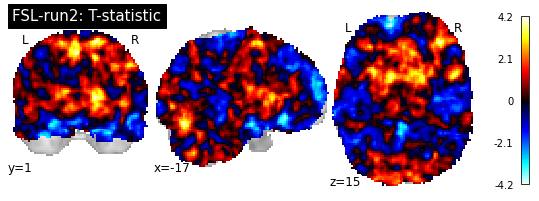

In [6]:
print("Replication of the original experiment")
show_gif('./figures/group-level-fsl.gif')

## SPM Results

In [6]:
study = './results/original/SPM'
spm_stat_orig = spm_stat(study)
study = './results/replicated-without-instrumentation/newdata/SPM/matlab2016b/'
spm_stat_replicate1 = spm_stat(study)
study = './results/replicated-without-instrumentation/newdata/SPM/matlab2021a/'
spm_stat_replicate2 = spm_stat(study)

study = './results/ds000001/fuzzy/p53/SPM-Octace/run1/'
spm_stat_replicate1 = spm_stat(study)
study = './results/ds000001/tools/SPM/Octave/'
spm_stat_replicate2 = spm_stat(study)


#print("Replication of the original experiment")
max_activation=4.2
#plot_stat_images(spm_stat_replicate1, spm_stat_replicate2, max_activation, [-17, 1, 15], 'SPM', 'T-statistic', spm_stat_orig)


Replication of the original experiment



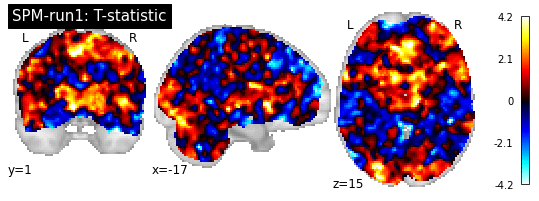

In [6]:
print("Replication of the original experiment")
#show_gif('./figures/group-level-spm-2016.gif')
show_gif('./figures/group-level-spm-2016.gif')

#print("Replication of the experiment between matlab versions R2016b vs R2021a")
#show_gif('./figures/group-level-spm-between-matlabs.gif')

#print("Replication of the experiment between matlab versions R2016b vs Octave")
#show_gif('./figures/group-level-spm-between-matlab-octave.gif')

## AFNI Results
We found that number of threads could affect the final results in AFNI processing.

In [5]:
afni_stat_orig = './results/original/AFNI/3dMEMA_result_t_stat_masked.nii.gz'
afni_stat_replicate1 = './results/ds000001/tools/AFNI/3dMEMA_result_t_stat_masked.nii.gz'
#afni_stat_replicate2 = './results/ds000001/tools/AFNI-4threads/3dMEMA_result_t_stat_masked.nii.gz'
afni_stat_replicate2 = './results/ds000001/fuzzy/p53/AFNI/run1/3dMEMA_result_t_stat_masked.nii.gz'

#print("Replication of the original experiment")
max_activation=4.2
#plot_stat_images(afni_stat_replicate1, afni_stat_replicate2, max_activation, [-17, 1, 15], 'AFNI', 'T-statistic', afni_stat_orig)

Replication of the original experiment with AFNI



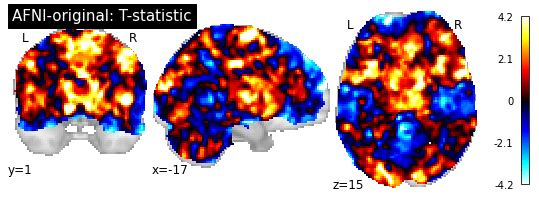

In [4]:
print("Replication of the original experiment with AFNI")
show_gif('./figures/group-level-afni.gif')

## Visualization of BT vs WT
### Tstats

In [117]:
tool_results = {}
tool_results['fsl'] = {}
tool_results['fsl']['act_deact'] = './figures/map-on-surf/fsl.nii.gz'
tool_results['spm'] = {}
tool_results['spm']['act_deact'] = './figures/map-on-surf/spm.nii.gz'
tool_results['afni'] = {}
tool_results['afni']['act_deact'] = './figures/map-on-surf/afni.nii.gz'

fsl_mca = {}
fsl_mca[1] = {}
fsl_mca[1]['act_deact'] = "./figures/map-on-surf/fsl_s1.nii.gz"
fsl_mca[2] = {}
fsl_mca[2]['act_deact'] = "./figures/map-on-surf/fsl_s2.nii.gz"
fsl_mca[3] = {}
fsl_mca[3]['act_deact'] = "./figures/map-on-surf/fsl_s3.nii.gz"

spm_mca = {}
spm_mca[1] = {}
spm_mca[1]['act_deact'] = "./figures/map-on-surf/spm_s1.nii.gz"
spm_mca[2] = {}
spm_mca[2]['act_deact'] = "./figures/map-on-surf/spm_s2.nii.gz"
spm_mca[3] = {}
spm_mca[3]['act_deact'] = "./figures/map-on-surf/spm_s3.nii.gz"

afni_mca = {}
afni_mca[1] = {}
afni_mca[1]['act_deact'] = "./figures/map-on-surf/afni_s1.nii.gz"
afni_mca[2] = {}
afni_mca[2]['act_deact'] = "./figures/map-on-surf/afni_s2.nii.gz"
afni_mca[3] = {}
afni_mca[3]['act_deact'] = "./figures/map-on-surf/afni_s3.nii.gz"


In [111]:
# Determine the scale of the activation colorbar
max_activation=4.2
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[0, 4, 32]
y_coords=[0, 24, 38]
z_coords=[-32, -18, 0, 12, 24, 40, 55]

to_display = afni_mca[3]['act_deact']
to_display = tool_results['fsl']['act_deact']
title_ = 'FSL'
#display = plotting.plot_stat_map(to_display, display_mode='x', cut_coords=x_coords, draw_cross=False, colorbar=True, title=title_, threshold=0.000001, vmax=max_activation)
#display = plotting.plot_stashow_gif('./figures/gif-tstats/btool.gif')t_map(to_display, cut_coords=y_coords, draw_cross=False, display_mode='y', threshold=0.000001, colorbar=False, vmax=max_activation)
#display = plotting.plot_stat_map(to_display, cut_coords=z_coords, draw_cross=False, display_mode='z', threshold=0.000001, colorbar=False, vmax=max_activation, title=title_)


Between tool variations



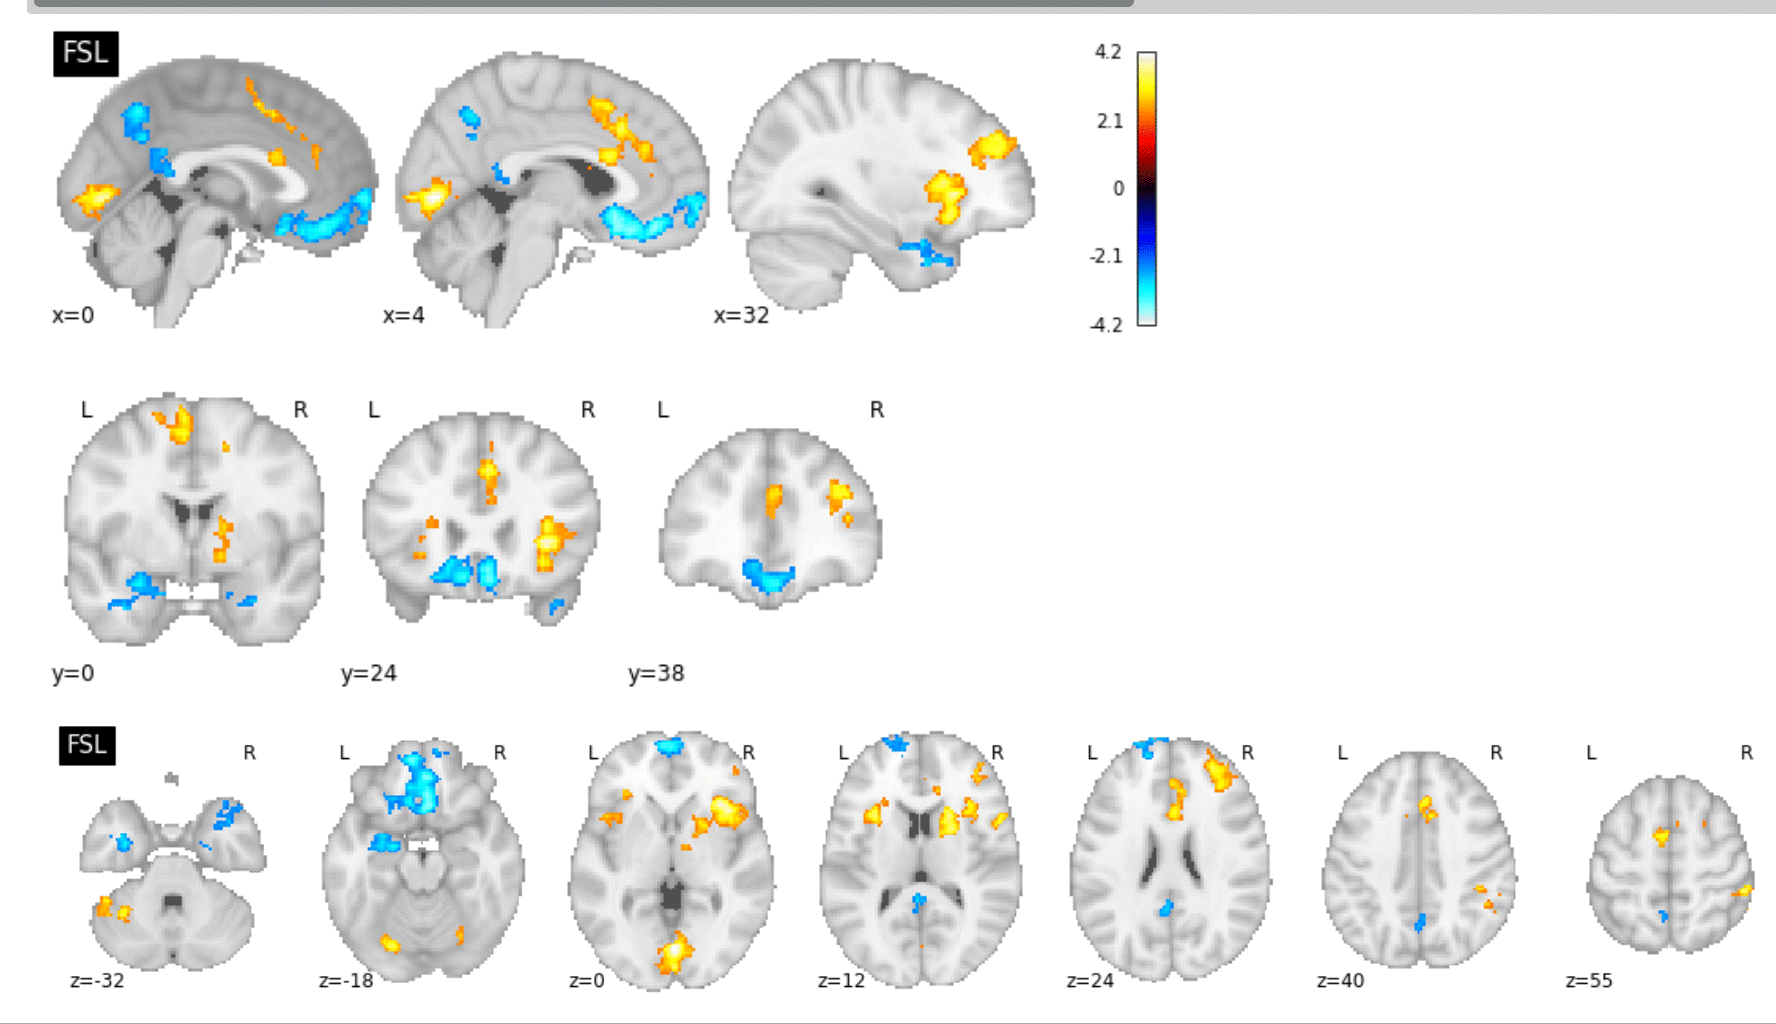

In [113]:
print("Between tool variations")
show_gif('./figures/gif-tstats/btool.gif')

Within tool (FSL) variations



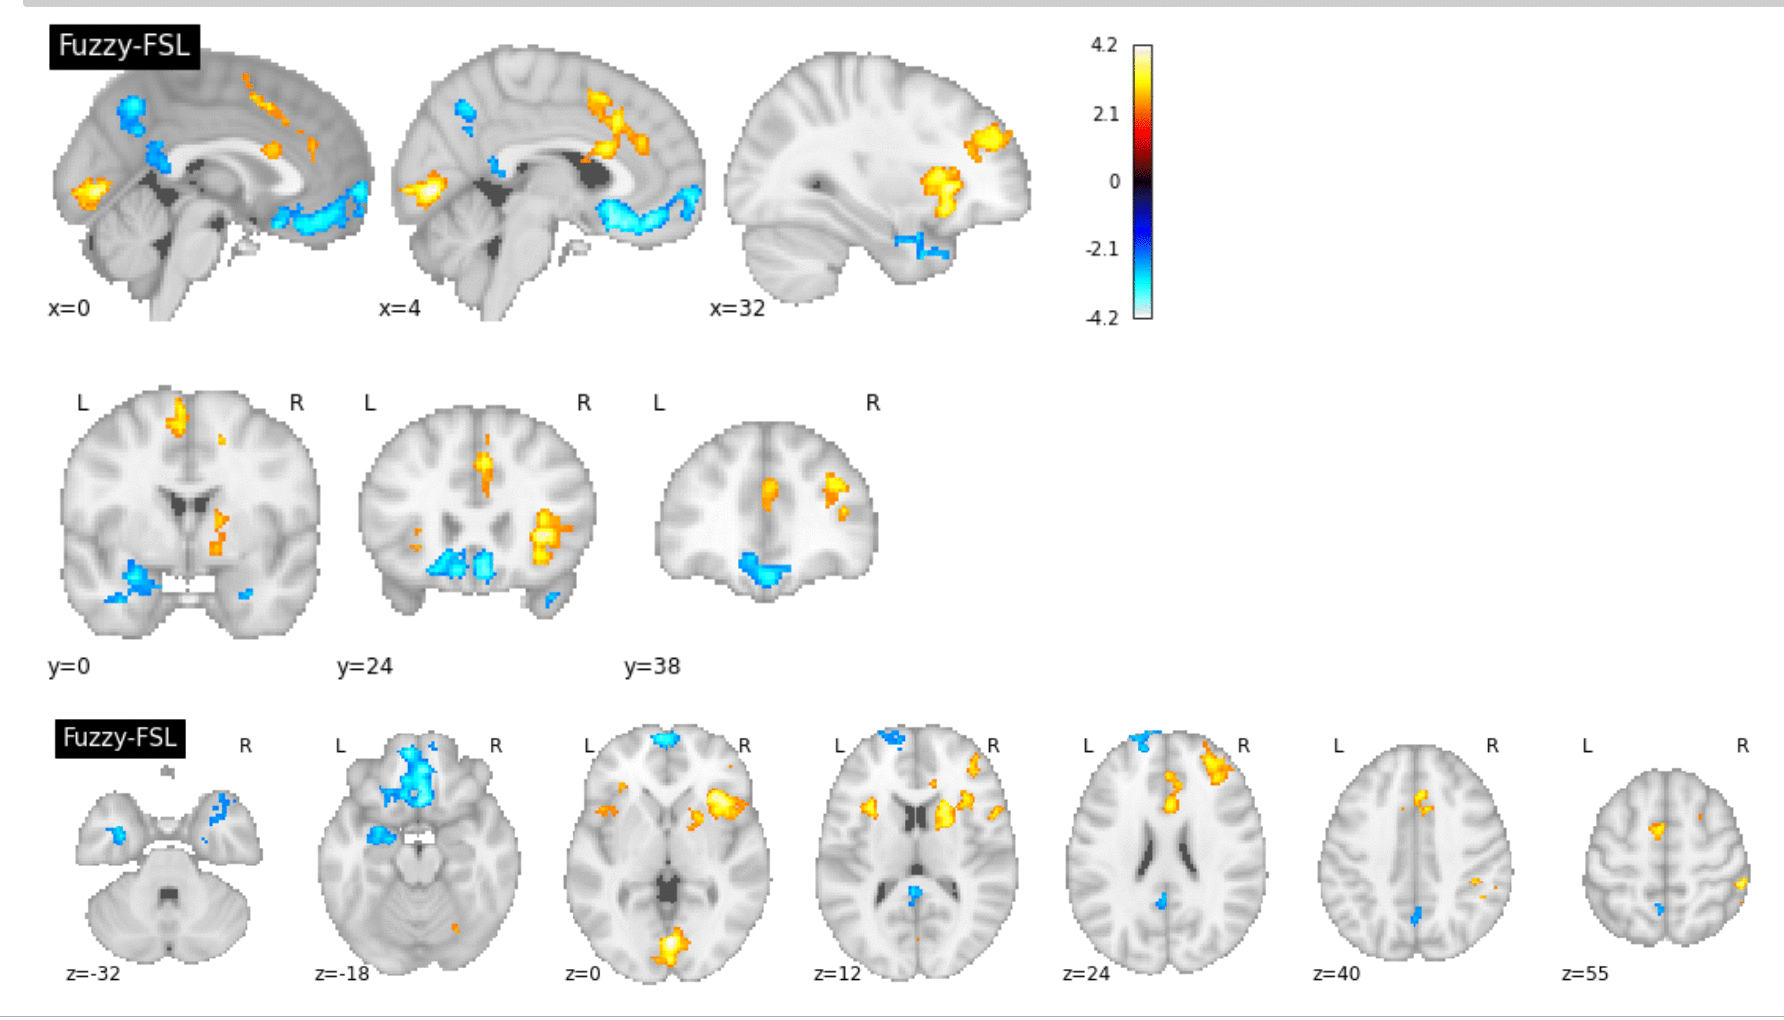

In [114]:
print("Within tool (FSL) variations")
show_gif('./figures/gif-tstats/fuzzy-fsl.gif')

Within tool (SPM) variations



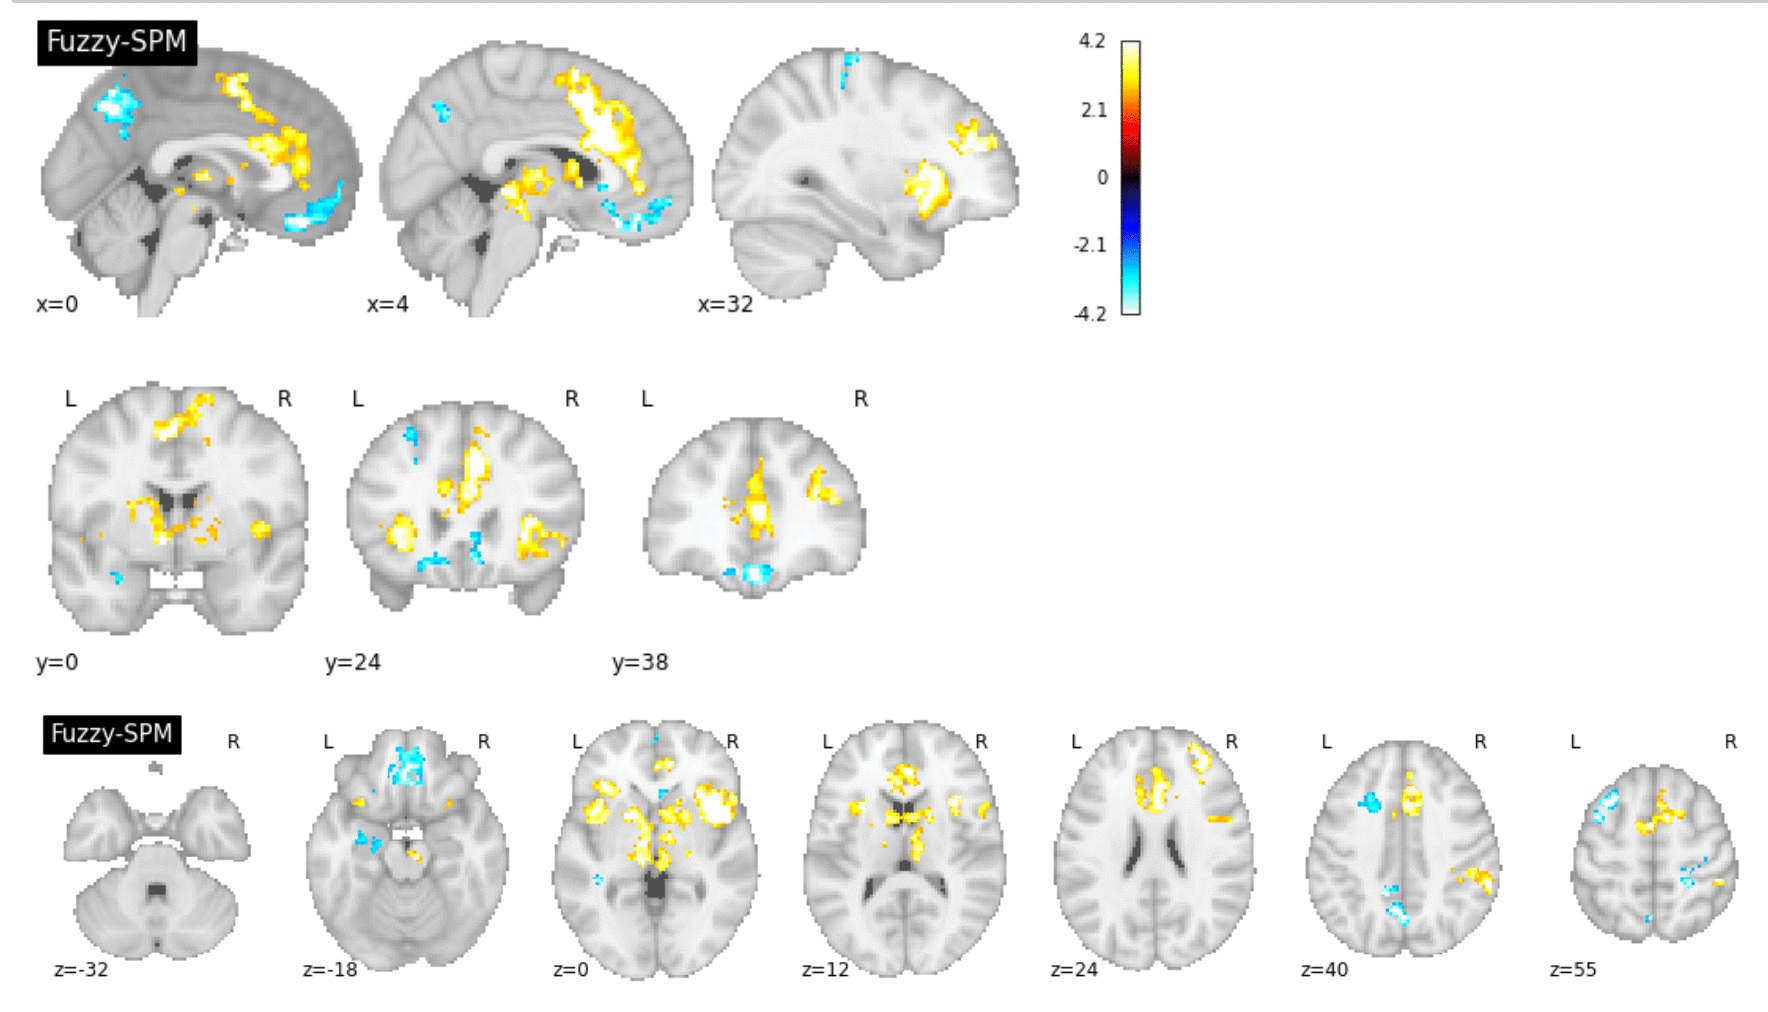

In [115]:
print("Within tool (SPM) variations")
show_gif('./figures/gif-tstats/fuzzy-spm.gif')

Within tool (AFNI) variations



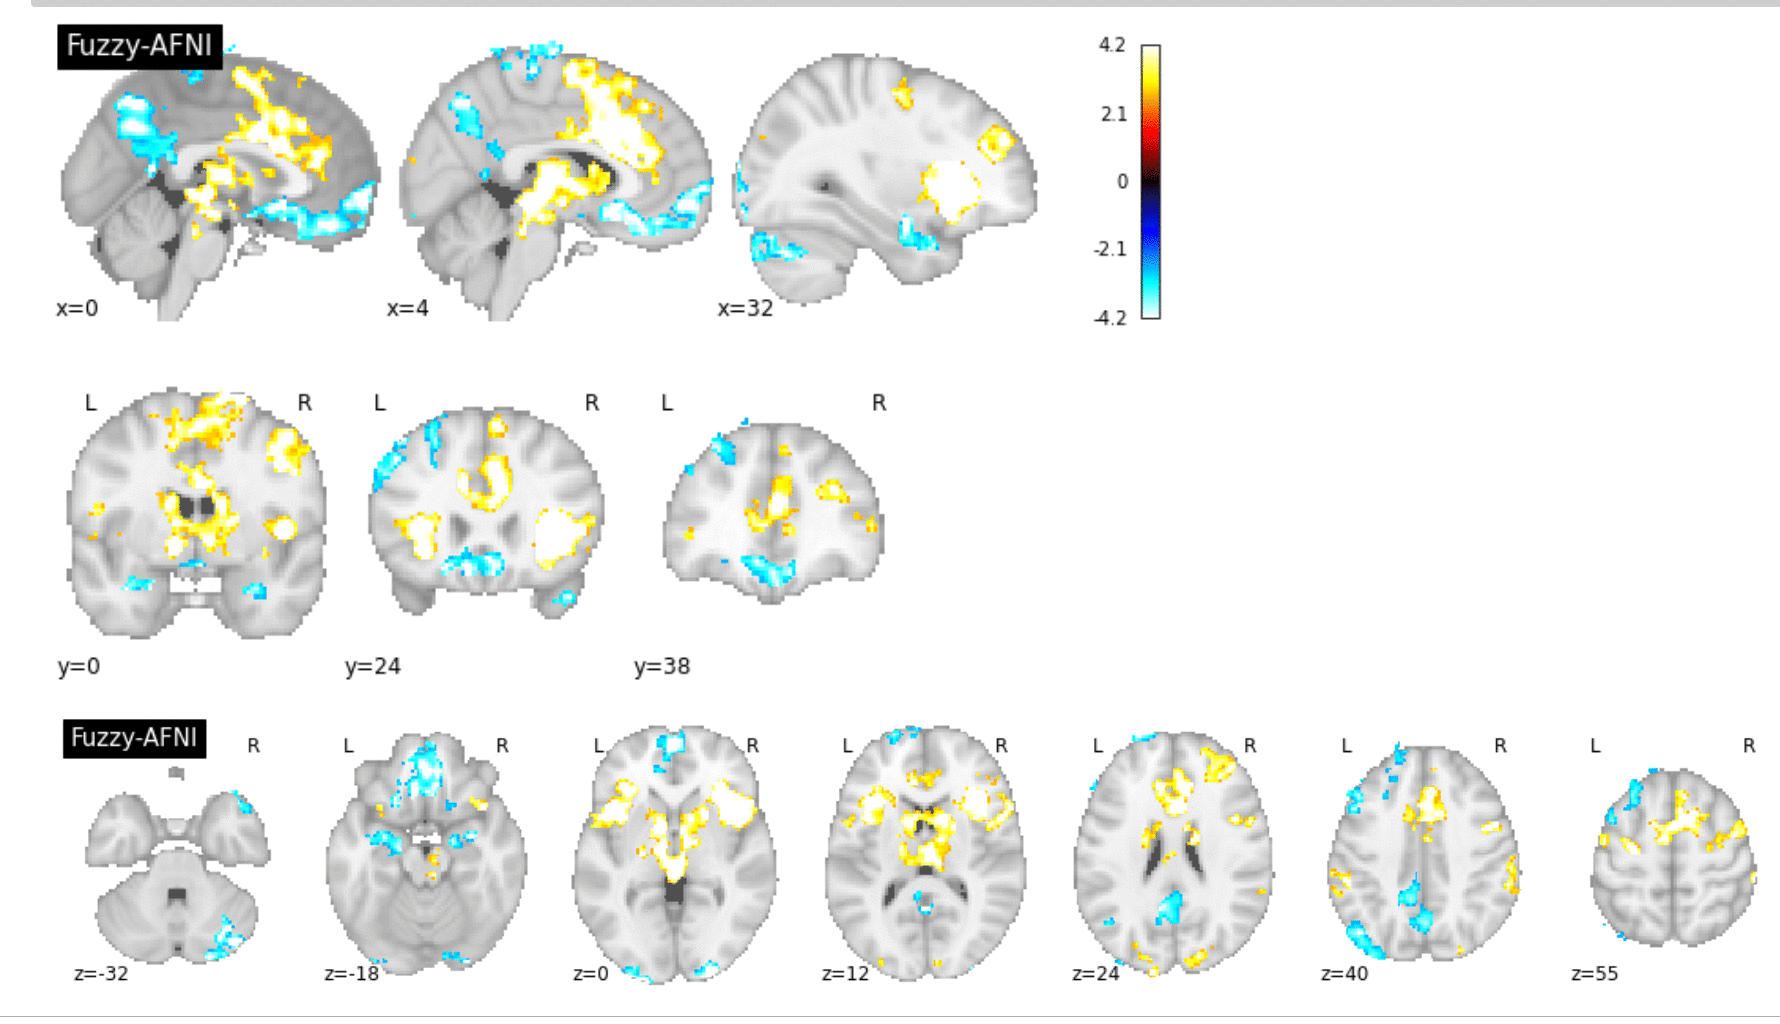

In [116]:
print("Within tool (AFNI) variations")
show_gif('./figures/gif-tstats/fuzzy-afni.gif')

In [ ]:
exc_sets = dict()
exc_sets["S1"] = (fsl_s1_mask_file, (fsl_s1_exc_set_file, fsl_s1_exc_set_file_neg), fsl_s1_stat_file)
exc_sets["S2"] = (fsl_s2_mask_file, (fsl_s2_exc_set_file, fsl_s2_exc_set_file_neg), fsl_s2_stat_file)
exc_sets["S3"] = (fsl_s3_mask_file, (fsl_s3_exc_set_file, fsl_s3_exc_set_file_neg), fsl_s3_stat_file)



#from lib import plot_excursion_sets
# Determine the scale of the activation colorbar
max_activation=4.2
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[4, 32]
y_coords=[38]
z_coords=[-32, -18, 0, 12, 24, 40, 58]

#plot_excursion_sets(exc_sets, max_activation, x_coords, y_coords, z_coords)

#from nilearn import plotting, surface, datasets
#parcellation = surface.load_surf_data('/home/Ali/Desktop/git_repo/fuzzy-neurotools/MNI-parcellation/3498446/lh.HCP-MMP1.annot')
#fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
#plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=parcellation,
#                       hemi='left', view='lateral',
#                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                       darkness=.5)


## Maps of standard deviations

In [98]:

def log10_of_img(img):
    img_ = nib.load(img)
    data_img = img_.get_fdata()
    log_data = np.log10(data_img)
    # NAN values to zero
    #log_data[np.isnan(log_data)] = 0.
    img_d_img = nib.Nifti1Image(log_data, img_.affine, header=img_.header)
    return img_d_img
import matplotlib

def nan_to_zero(img):
    img_ = nib.load(img)
    data_img = img_.get_fdata()
    #log_data = np.log10(data_img+1.0)
    # NAN values to zero
    #log_data[np.isnan(log_data)] = 0.
    data_img = np.nan_to_num(data_img)
    max_ = np.max(data_img)
    img_d_img = nib.Nifti1Image(data_img, img_.affine, header=img_.header)
    return img_d_img, max_



/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  if sys.path[0] == '':
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


<Figure size 1080x576 with 0 Axes>

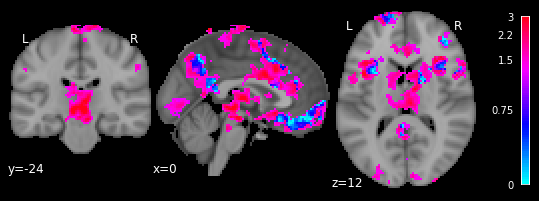

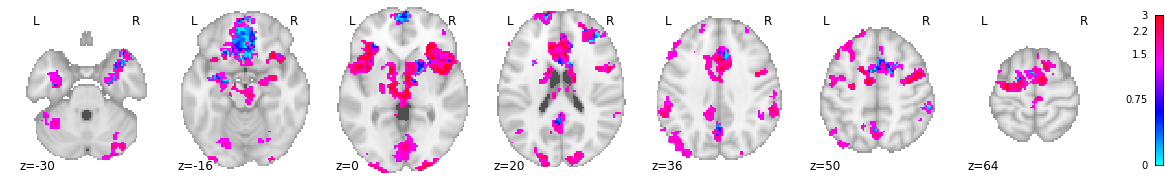

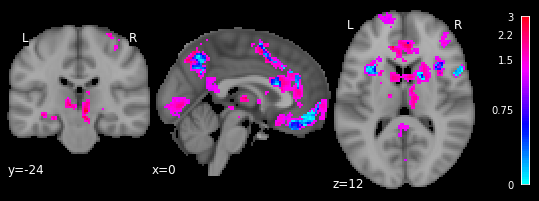

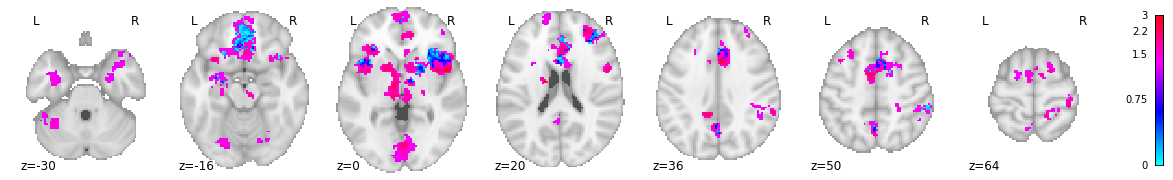

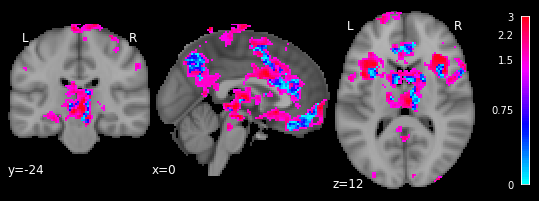

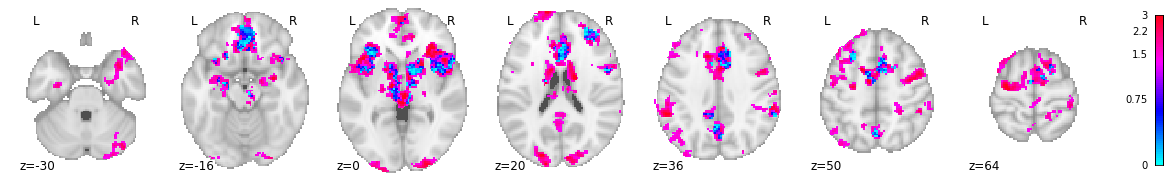

In [137]:
z_coords = [-30, -16, 0, 20, 36, 50, 64]
cmp='hsv'
vmax_ = 3
clbar = True
#vmax_ = None
fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/{}-thresh-std.nii.gz'.format(pair_)
    title=pair_.upper()
    #img_ = nan_to_zero(img_) #norm=colors.LogNorm(vmin=0, vmax=1.8)
    display = plotting.plot_stat_map(img_,vmax=vmax_, black_bg=True,display_mode='ortho', colorbar=clbar,
                                     norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmp,title=None,cut_coords=[0,-24,12], draw_cross=False)
    #display.title('Your title', size=30)
    #display.annotate(size=30)
    display.savefig('paper/figures/plots/{}-thresh-ortho.png'.format(pair_)) 
    #z_coords = plotting.find_cut_slices(img_,direction='z', n_cuts=7, spacing='auto')

    display = plotting.plot_stat_map(img_,vmax=vmax_, display_mode='z', cut_coords=z_coords,#symmetric_cbar=True,
                                      norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmp,colorbar=clbar, draw_cross=False)
    display.savefig('paper/figures/plots/{}-thresh-z.png'.format(pair_)) 


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 1080x576 with 0 Axes>

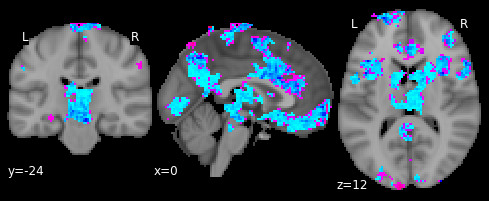

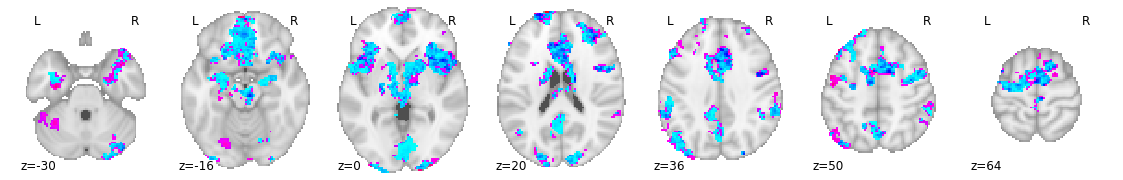

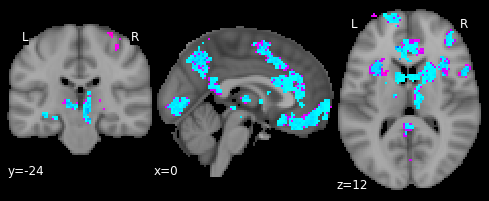

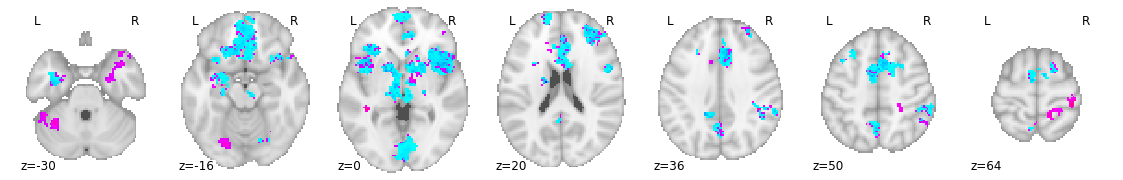

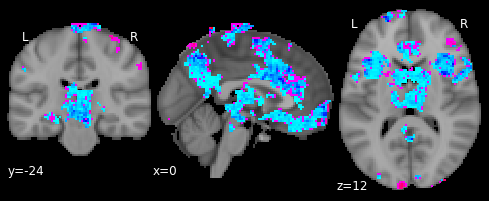

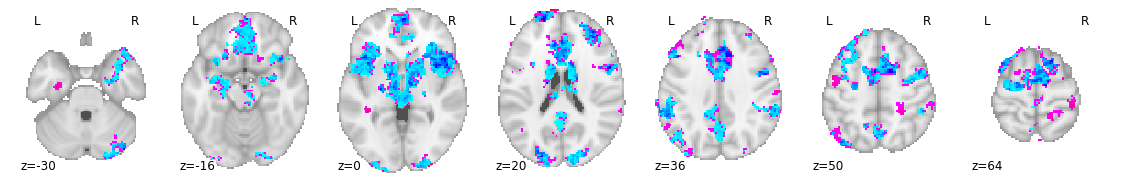

In [130]:

fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/fuzzy-{}-thresh-std.nii.gz'.format(pair_)
    title=pair_.upper()
    display = plotting.plot_stat_map(img_,vmax=vmax_, black_bg=True,display_mode='ortho', colorbar=clbar,
                                      norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmp,cut_coords=[0,-24,12], draw_cross=False)
    display.savefig('paper/figures/plots/fuzzy-{}-thresh-ortho.png'.format(pair_)) 

    display = plotting.plot_stat_map(img_, vmax=vmax_, display_mode='z', cut_coords=z_coords,
                                      norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                      cmap=cmp,colorbar=clbar, draw_cross=False)
    display.savefig('paper/figures/plots/fuzzy-{}-thresh-z.png'.format(pair_)) 


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 1080x576 with 0 Axes>

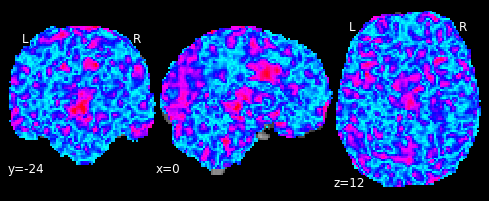

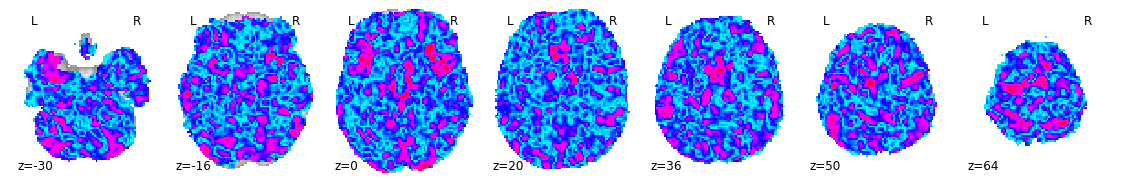

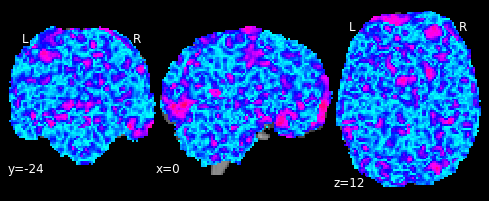

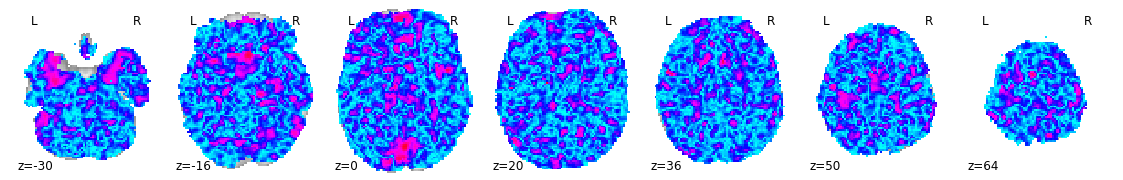

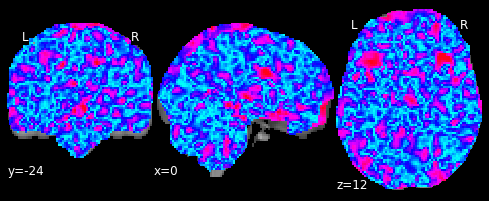

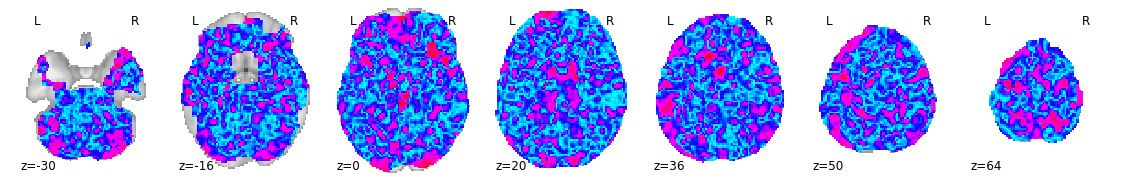

In [131]:

fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/{}-unthresh-std.nii.gz'.format(pair_)
    display = plotting.plot_stat_map(img_,
                                     vmax=vmax_, black_bg=True,display_mode='ortho', colorbar=clbar,
                                     norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmp,cut_coords=[0,-24,12], draw_cross=False)
    display.savefig('paper/figures/plots/{}-unthresh-ortho.png'.format(pair_)) 

    display = plotting.plot_stat_map(img_, vmax=vmax_, display_mode='z', cut_coords=z_coords,
                                      norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                      cmap=cmp,colorbar=clbar, draw_cross=False)
    display.savefig('paper/figures/plots/{}-unthresh-z.png'.format(pair_)) 


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


<Figure size 1080x576 with 0 Axes>

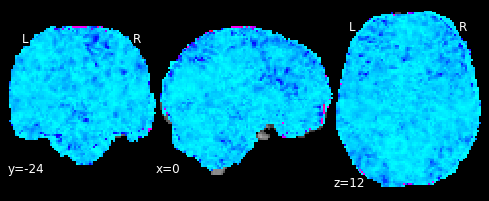

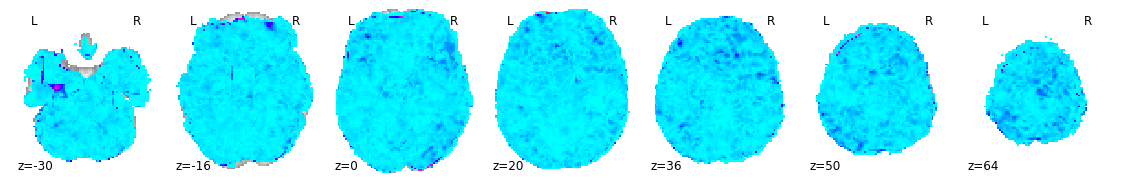

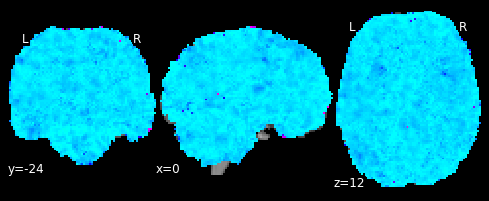

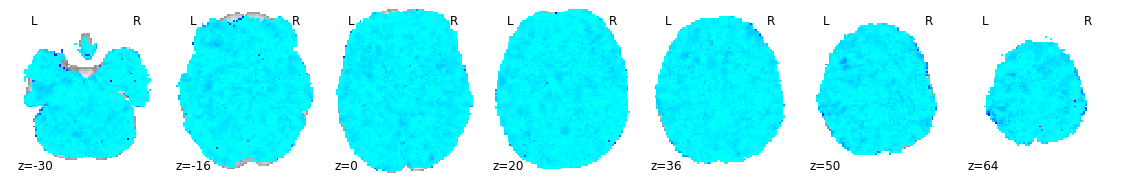

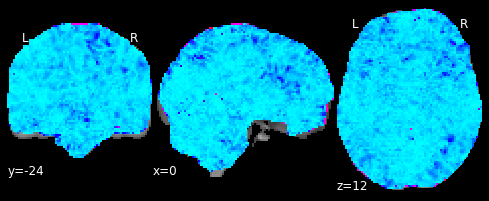

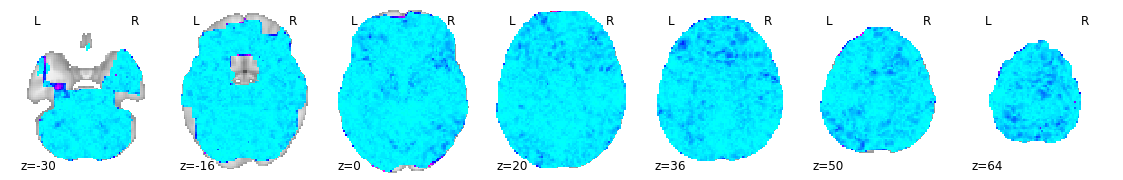

In [132]:

fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/fuzzy-{}-unthresh-std.nii.gz'.format(pair_)
    display = plotting.plot_stat_map(img_,
                                     vmax=vmax_, black_bg=True,display_mode='ortho', colorbar=clbar,
                                      norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmp,cut_coords=[0,-24,12], draw_cross=False)
    display.savefig('paper/figures/plots/fuzzy-{}-unthresh-ortho.png'.format(pair_)) 

    display = plotting.plot_stat_map(img_, vmax=vmax_, display_mode='z', cut_coords=z_coords,
                                      cmap=cmp,colorbar=clbar, draw_cross=False)
    display.savefig('paper/figures/plots/fuzzy-{}-unthresh-z.png'.format(pair_)) 


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  """
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 1080x576 with 0 Axes>

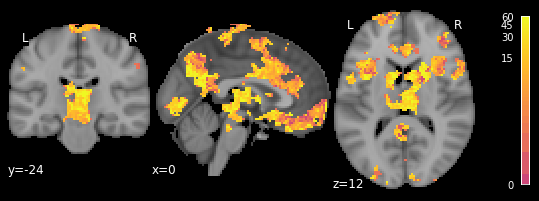

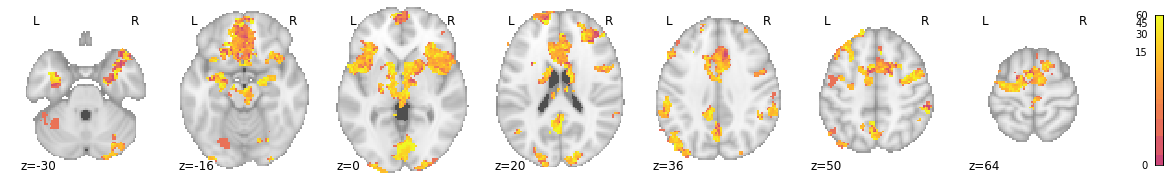

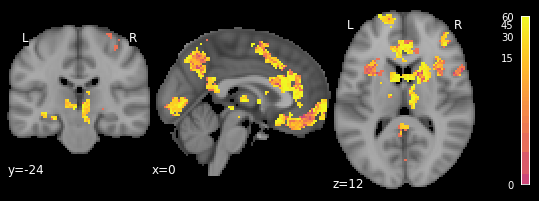

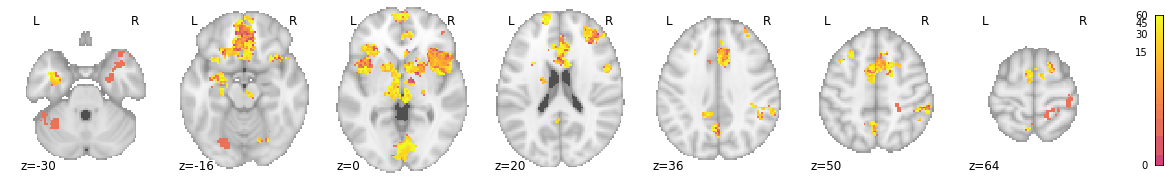

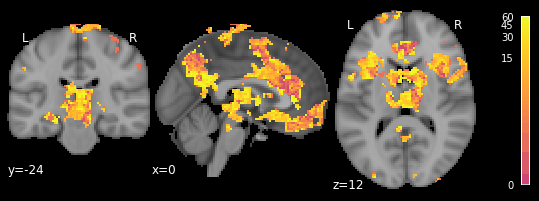

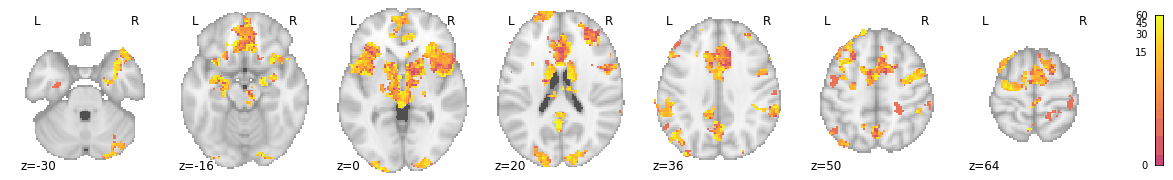

In [138]:
fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/ratio-{}-thresh.nii.gz'.format(pair_)
    display = plotting.plot_stat_map(img_,vmax=60, black_bg=True,display_mode='ortho', colorbar=clbar,
                                     norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap="plasma",cut_coords=[0,-24,12], draw_cross=False)
    display.savefig('paper/figures/plots/ratio-{}-thresh-ortho.png'.format(pair_)) 

    display = plotting.plot_stat_map(img_,vmax=60, display_mode='z', cut_coords=z_coords, draw_cross=False,
                                     norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     colorbar=clbar,cmap="plasma")
    display.savefig('paper/figures/plots/ratio-{}-thresh-z.png'.format(pair_)) 


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  """
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  if __name__ == '__main__':


<Figure size 1080x576 with 0 Axes>

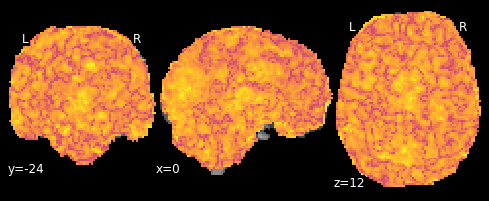

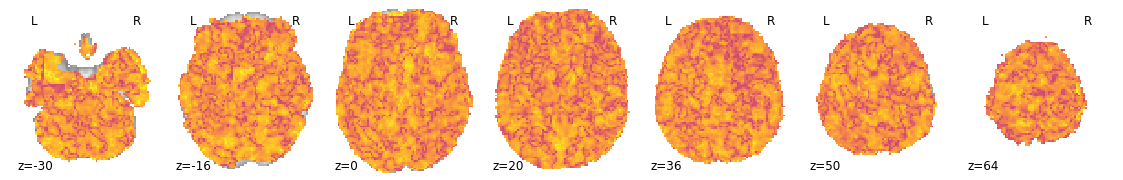

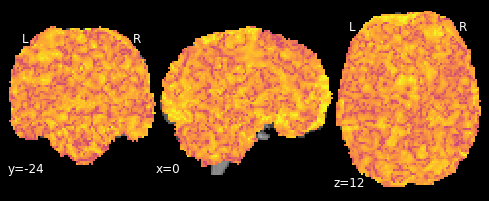

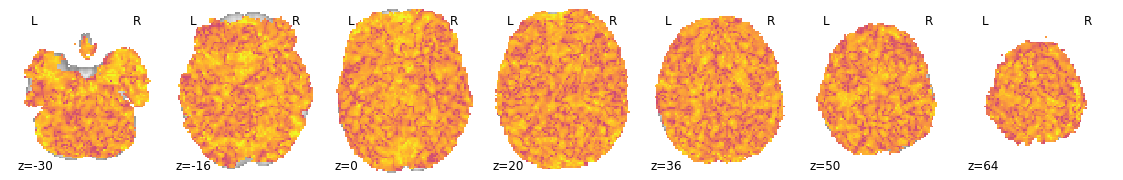

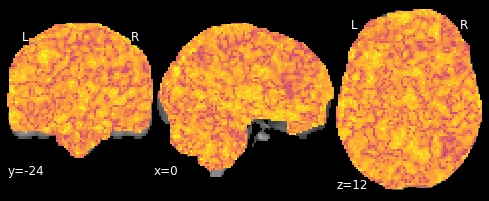

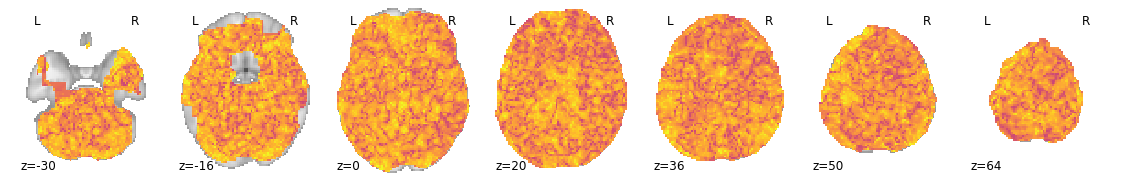

In [134]:
fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/ratio-{}-unthresh.nii.gz'.format(pair_)
    display = plotting.plot_stat_map(img_,vmax=60, black_bg=True,display_mode='ortho',  colorbar=clbar,
                                      norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap="plasma",cut_coords=[0,-24,12], draw_cross=False)
    display.savefig('paper/figures/plots/ratio-{}-unthresh-ortho.png'.format(pair_)) 
    display = plotting.plot_stat_map(img_,vmax=60, display_mode='z', cut_coords=z_coords, draw_cross=False,
                                     norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     colorbar=clbar, cmap="plasma")
    display.savefig('paper/figures/plots/ratio-{}-unthresh-z.png'.format(pair_)) 


## Maps of BT/WT ratio

<Figure size 1080x576 with 0 Axes>

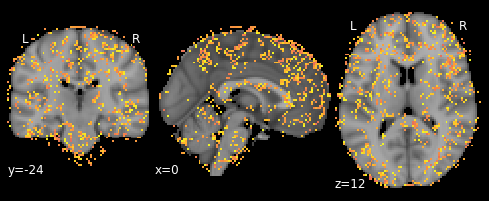

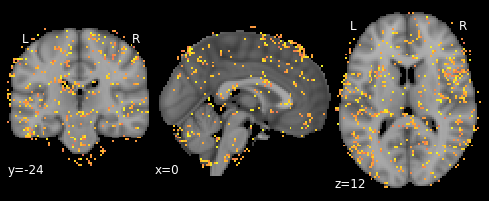

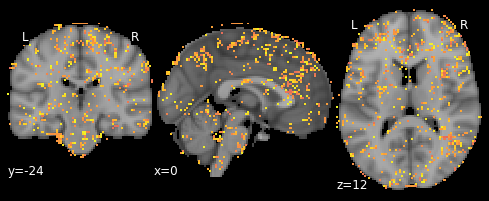

In [141]:
fig = plt.figure(figsize=(15, 8))
for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
    img_ = 'figures/map-on-surf/std/clusters/correlated-maps-unthresh-{}.nii.gz'.format(pair_)
    
    #img_ = log10_of_img(img_)
    display = plotting.plot_stat_map(img_,vmax=2, black_bg=True,display_mode='ortho',  colorbar=False,
                                     threshold = 0.5,
                                     cmap="plasma",cut_coords=[0,-24,12], draw_cross=False)
    #display.title('Your title', size=30)
    #display.annotate(size=30)
    display.savefig('paper/figures/plots/correlated-{}-unthresh-ortho.png'.format(pair_)) 
    #z_coords = plotting.find_cut_slices(img_, direction='z', n_cuts=7, spacing='auto')

    #display = plotting.plot_stat_map(img_,vmax=2.3, display_mode='z', cut_coords=z_coords, draw_cross=True,
    #                                 threshold = 0.5,
    #                                 colorbar=False, cmap="hsv")
    #display.savefig('paper/figures/plots/correlated-{}-unthresh-z.png'.format(pair_)) 

